In [1]:
%matplotlib inline

# Deep Learning with PyTorch ``torch.autograd`` Tutorial

This tutorial is adapted from [the PyTorch Tutorials](https://pytorch.org/tutorials/), valuable references for learning the fundamentals of Deep Learning with PyTorch. We highly recommend exploring other tutorials for a deeper understanding and additional topics.

In this tutorial, we'll learn about ``torch.autograd``, which serves as PyTorch's automatic differentiation engine, driving the training of neural networks. This section aims to provide you with a conceptual grasp of how autograd contributes to the training process of a neural network.

## Background

Neural networks (NNs) consist of nested functions applied to input data. The functions are defined by *parameters*, comprising weights and biases, which are stored as tensors in PyTorch.

### Neural Network Training in Two Steps:

**Step 1: Forward Propagation**: During forward prop, the neural network (NN) formulates its best estimate of the correct output. It processes the input data through each of its functions to generate this prediction.

**Step 2: Backward Propagation**: In backpropagation, the NN fine-tunes its parameters based on the error in its prediction. This involves traversing backward from the output, gathering the derivatives of the error concerning the function parameters (*gradients*), and optimizing the parameters through gradient descent. For a more comprehensive guide to backpropagation, refer to this [video by 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

## Application in PyTorch

Examining a single training step, consider the following example. We load a pre-trained ResNet18 model from the ``torchvision`` library. A random data tensor is generated to represent a single image with 3 channels, a height and width of 64 each, along with its associated ``label`` initialized to random values. In pre-trained models, the label typically has a shape of (1, 1000).

<div class="alert alert-info"><h4>Note</h4><p>This tutorial is specifically designed for CPU usage and is not compatible with GPU devices, even if tensors are transferred to CUDA.</p></div>

The code below accomplishes the following tasks:

1. Import the PyTorch library (`torch`) and the ResNet18 model along with its predefined weights (`resnet18`, `ResNet18_Weights`).
2. Load the ResNet18 model with default weights using the `resnet18` function and specifying `weights=ResNet18_Weights.DEFAULT`.
3. Create a random data tensor (`data`) representing a single image with 3 channels, and a height and width of 64 each, using `torch.rand`.
4. Initialize a label tensor (`labels`) with random values, where the label in pre-trained models typically has a shape of (1, 1000).

In [2]:
# Import necessary libraries
import torch
from torchvision.models import resnet18, ResNet18_Weights

# Load the pre-trained ResNet18 model with default weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Generate a random data tensor representing a single image with 3 channels,
# and a height and width of 64 each
data = torch.rand(1, 3, 64, 64)

# Initialize the corresponding label tensor with random values
labels = torch.rand(1, 1000)

Subsequently, the input data is processed through each layer of the model to generate a prediction. This step is referred to as the **forward pass**.

In [3]:
# Perform the forward pass by passing the input data through the model
prediction = model(data)  # forward pass

Utilizing the model's prediction and the associated label, we compute the error (``loss``). Subsequently, the error needs to be backpropagated through the network. Initiating backward propagation is achieved by invoking ``.backward()`` on the error tensor. The Autograd module then computes and retains the gradients for each model parameter in the parameter's ``.grad`` attribute.

In [4]:
# Calculate the error (loss) by summing the differences between 
# the model's prediction and the labels
loss = (prediction - labels).sum()

# Initiate the backward pass by calling .backward() on the loss tensor
loss.backward()  # backward pass

Subsequently, an optimizer is instantiated, specifically Stochastic Gradient Descent (SGD) with a learning rate of 0.01 and [momentum](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) set to 0.9. All parameters of the model are then registered with the optimizer.

In [5]:
# Instantiate an optimizer for Stochastic Gradient Descent (SGD)
# - The model.parameters() provides the parameters that need optimization
# - lr=1e-2 sets the learning rate to 0.01
# - momentum=0.9 sets the momentum to 0.9, a technique enhancing SGD convergence
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

Finally, we utilize the ``.step()`` method to start the gradient descent process. The optimizer then adjusts each model parameter based on the respective gradient stored in the ``.grad`` attribute.

In [6]:
# Initiate the gradient descent step using the optimizer
# This updates each model parameter based on the gradients stored in .grad
optim.step()  # gradient descent

Now, you possess all the necessary elements to train your neural network. Subsequent sections will elaborate on the functionalities of autograd.

--------------




## Gradients Collection in Autograd

Explore how ``autograd`` gathers gradients by examining the creation of two tensors, ``a`` and ``b``, each marked with ``requires_grad=True``. This indication informs ``autograd`` to track every operation performed on these tensors.

In [7]:
# Create a tensor 'a' with values [2., 3.]
# and enable gradient tracking using requires_grad=True
a = torch.tensor([2., 3.], requires_grad=True)

# Create another tensor 'b' with values [6., 4.]
# and enable gradient tracking using requires_grad=True
b = torch.tensor([6., 4.], requires_grad=True)


We generate a new tensor ``Q`` using the tensors ``a`` and ``b``.

\begin{align}Q = 3a^3 - b^2\end{align}

In [8]:
# Define a new tensor 'Q' using mathematical operations 
# on tensors 'a' and 'b'
# Q is calculated as 3 times the cube of 'a' minus the square of 'b'
Q = 3 * a**3 - b**2

Suppose that ``a`` and ``b`` represent parameters of a neural network (NN), and ``Q`` signifies the error. During NN training, we aim to obtain the gradients of the error with respect to the parameters, i.e.

\begin{align}\frac{\partial Q}{\partial a} = 9a^2\end{align}

\begin{align}\frac{\partial Q}{\partial b} = -2b\end{align}


Upon invoking ``.backward()`` on tensor ``Q``, autograd computes these gradients and retains them in the corresponding tensors' ``.grad`` attribute.

To accommodate the fact that ``Q`` is a vector, we must explicitly provide a ``gradient`` argument in ``Q.backward()``. The ``gradient`` tensor should possess the same shape as ``Q`` and signify the gradient of ``Q`` with respect to itself, i.e.

\begin{align}\frac{dQ}{dQ} = 1\end{align}

Alternatively, we can consolidate the elements of ``Q`` into a scalar and invoke backward implicitly using the expression ``Q.sum().backward()``.

In [9]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

The gradients are now stored in the ``a.grad`` and ``b.grad`` attributes.

In [10]:
# Check if the collected gradients are correct for tensor 'a'
# The expression 9*a**2 calculates the expected gradient for 'a'
# Compare the calculated gradient with the expected gradient and print the result
print(9*a**2 == a.grad)

# Check if the collected gradients are correct for tensor 'b'
# The expression -2*b calculates the expected gradient for 'b'
# Compare the calculated gradient with the expected gradient and print the result
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


### Vector Calculus using ``autograd``

In mathematical terms, if you have a vector-valued function $\vec{y}=f(\vec{x})$, then the gradient of $\vec{y}$ with respect to $\vec{x}$ is represented as a Jacobian matrix $J$:

\begin{align}J
     =
      \left(\begin{array}{cc}
      \frac{\partial \bf{y}}{\partial x_{1}} &
      ... &
      \frac{\partial \bf{y}}{\partial x_{n}}
      \end{array}\right)
     =
     \left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}


In a general sense, ``torch.autograd`` functions as an engine for computing vector-Jacobian products. Specifically, it calculates the product $J^{T}\cdot \vec{v}$ for any given vector $\vec{v}$.

If $\vec{v}$ happens to represent the gradient of a scalar function $l=g\left(\vec{y}\right)$:

\begin{align}\vec{v}
   =
   \left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}\end{align}

In accordance with the chain rule, the vector-Jacobian product corresponds to the gradient of $l$ with respect to $\vec{x}$:

\begin{align}J^{T}\cdot \vec{v}=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\left(\begin{array}{c}
      \frac{\partial l}{\partial y_{1}}\\
      \vdots\\
      \frac{\partial l}{\partial y_{m}}
      \end{array}\right)=\left(\begin{array}{c}
      \frac{\partial l}{\partial x_{1}}\\
      \vdots\\
      \frac{\partial l}{\partial x_{n}}
      \end{array}\right)\end{align}

The concept of the vector-Jacobian product is applied in the previous example, where ``external_grad`` symbolizes the vector $\vec{v}$.

## Computational Graph

In a conceptual sense, autograd maintains a record of data (tensors) and all executed operations, including the resulting new tensors, within a directed acyclic graph (DAG) composed of [Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function) objects. In this graph, the input tensors serve as leaves, while the output tensors act as roots. By traversing this graph from roots to leaves, you can automatically compute gradients utilizing the chain rule.

During a forward pass, autograd performs two simultaneous tasks:

- Executes the specified operation to compute a resultant tensor.
- Preserves the *gradient function* of the operation within the DAG.

The initiation of the backward pass occurs when ``.backward()`` is invoked on the DAG root. Subsequently, ``autograd`` undertakes the following steps:

- Computes the gradients from each ``.grad_fn``,
- Aggregates these gradients in the corresponding tensor's ``.grad`` attribute,
- Utilizes the chain rule to propagate the gradients all the way back to the leaf tensors.

Here is a graphical depiction of the DAG in our example. In the graph, the arrows indicate the direction of the forward pass. The nodes correspond to the backward functions of each operation executed during the forward pass. The leaf nodes, highlighted in blue, symbolize our leaf tensors ``a`` and ``b``.

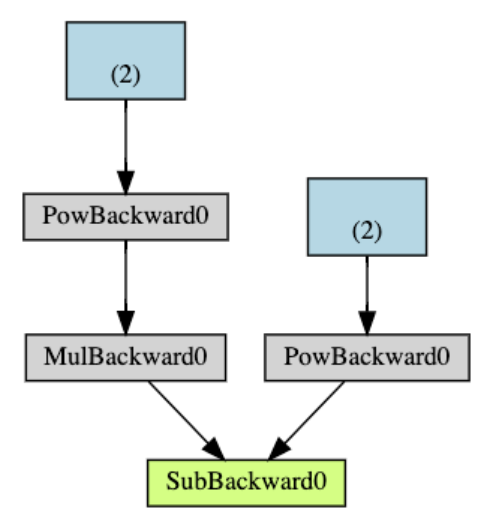

<div class="alert alert-info"><h4>Note</h4><p>**DAGs are Dynamic in PyTorch**
It's crucial to understand that the graph is dynamically recreated in PyTorch. After every ``.backward()`` invocation, autograd initiates the construction of a new graph. This feature enables the incorporation of control flow statements in your model. You have the flexibility to alter the shape, size, and operations at each iteration as necessary.</p></div>

### Exclusion from the DAG

``torch.autograd`` monitors operations on all tensors with the ``requires_grad`` flag set to ``True``. Tensors that don't need gradients can have this attribute set to ``False``, removing them from the computation of the gradient DAG.

The output tensor of an operation will necessitate gradients, even if only a single input tensor has ``requires_grad=True``.

In [11]:
# Create a random tensor 'x' with shape (5, 5)
x = torch.rand(5, 5)

# Create another random tensor 'y' with the same shape (5, 5)
y = torch.rand(5, 5)

# Create a random tensor 'z' with shape (5, 5) and set requires_grad=True
z = torch.rand((5, 5), requires_grad=True)

# Perform element-wise addition on tensors 'x' and 'y', resulting in tensor 'a'
a = x + y
# Check if 'a' requires gradients and print the result
print(f"Does `a` require gradients? : {a.requires_grad}")

# Perform element-wise addition on tensors 'x' and 'z', resulting in tensor 'b'
b = x + z
# Check if 'b' requires gradients and print the result
print(f"Does `b` require gradients?: {b.requires_grad}")

Does `a` require gradients? : False
Does `b` require gradients?: True


In neural networks, parameters that do not compute gradients are commonly referred to as **frozen parameters**. Freezing a portion of your model is beneficial when you anticipate not needing the gradients of those parameters in advance. This practice provides performance benefits by minimizing autograd computations.

During fine-tuning, it is common to freeze the majority of the model and selectively adjust only the classifier layers for making predictions on new labels. Let's go through a brief example to illustrate this. Similar to before, we load a pre-trained ResNet18 model and freeze all its parameters.

In [12]:
from torch import nn, optim

# Load a pretrained ResNet18 model
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all the parameters in the network
# Iterate through all parameters in the model and set requires_grad to False
for param in model.parameters():
    param.requires_grad = False

Suppose we aim to fine-tune the model on a new dataset with 10 labels. In ResNet, the classifier corresponds to the last linear layer, denoted as ``model.fc``. To achieve this, we can replace it with a new linear layer, which is unfrozen by default, serving as our classifier.

In [13]:
# Replace the last linear layer (classifier) in the model with a new linear layer
# The new linear layer has an input size of 512 and an output size of 10 (for 10 labels)
model.fc = nn.Linear(512, 10)

At this point, all parameters in the model, except for those belonging to ``model.fc``, are now frozen. The only parameters that undergo gradient computations are the weights and biases of ``model.fc``.

In [14]:
# Instantiate an optimizer for Stochastic Gradient Descent (SGD)
# Only the parameters of the classifier (model.fc) will be optimized
# lr=1e-2 sets the learning rate to 0.01, and momentum=0.9 sets the momentum to 0.9
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

It's worth noting that even though all parameters are registered in the optimizer, only the weights and bias of the classifier are computing gradients and consequently being updated in the gradient descent process.

A similar exclusionary functionality is accessible as a context manager through [torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html).

--------------


